In [1]:
import numpy as np
import scipy 
from scipy import integrate
import matplotlib.pyplot as plt
import networkx as nx
import time
import random
import matplotlib.animation
from IPython.display import HTML

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import pylab as plb
plb.rcParams['font.size'] = 12
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120

In [169]:
#Matrix which maps a node-valued vector to a boundary node-valued vector
#Graphs must have a real-valued 'pbdyVal' for each boundary node 
# (and should not have a 'pbdyVal' attribute for interior nodes)
def projB(G):
    j = 0 # j is the index of the boundary node
    numNodes = G.number_of_nodes()
    numBdyNodes = len(list(nx.get_node_attributes(G,'pbdyVal')))
    ProjB = np.zeros((numBdyNodes,numNodes))
    for i, node in enumerate(G.nodes()): # i is the index of the node
        if 'pbdyVal' in nx.nodes(G)[node]: #checks if there is a p attribute for node i
            ProjB[j,i] = 1
            j+=1
    return ProjB

#Matrix which maps a node-valued vector to an interior (not boundary) node-valued vector
def projI(G):
    j = 0 # j is the index of the boundary node
    numNodes = G.number_of_nodes()
    numIntNodes = numNodes - len(list(nx.get_node_attributes(G,'pbdyVal')))
    ProjI = np.zeros((numIntNodes,numNodes))
    for i, node in enumerate(G.nodes()): # i is the index of the node
        if 'pbdyVal' not in nx.nodes(G)[node]: #checks if there is a p attribute for node i
            ProjI[j,i] = 1
            j+=1
    return ProjI

#Creates a graph consisting solely of the boundary nodes of G (with attributes inherited). 
#Useful for plotting the inflow and outflow at the boundary nodes.
def G_boundary(G):
    Gb = G.copy()
    for i, node in enumerate(G.nodes()):
        if 'pbdyVal' not in nx.nodes(G)[node]: 
            Gb.remove_node(node)
    Gb.remove_edges_from(G.edges())
    return Gb

#Further breaks it down into source and sink BASED ON VALUES OF 'sign(q)', NOT 'sign(pbdyVal)'
def G_source(G):
    Gb = G_boundary(G)
    Gsource = Gb.copy()
    for i, node in enumerate(Gb.nodes()):
        if nx.get_node_attributes(Gb,'q')[node] >= 0: #sources have q<0
            Gsource.remove_node(node)
    Gsource.remove_edges_from(G.edges())
    return Gsource

def G_sink(G):
    Gb = G_boundary(G)
    Gsink = Gb.copy()
    for i, node in enumerate(Gb.nodes()):
        if nx.get_node_attributes(Gb,'q')[node] < 0: #sinks have q>0, also q=0 by this convention
            Gsink.remove_node(node)
    Gsink.remove_edges_from(G.edges())
    return Gsink

#Given a list of Graphs with attributes p(t), Q(t), assigns the time-averages as attributes
# (good for making plots where all you care about is the time-averaged quantities). 
def averaged_flow_network(GList,pArr,QArr):
    GAvg = GList[0].copy()  #Copies over some useful attributes we'll need:  planarPos, pBdyVal, A0. 
    DeltaT = (nx.incidence_matrix(GAvg, oriented=True)).toarray()
    pAvg = np.mean(pArr,axis=0)
    QAvg = np.mean(QArr,axis=0)
    qAvg = DeltaT.dot(QAvg)
    for i, node in enumerate(GAvg.nodes()):
        nx.set_node_attributes(GAvg,{node: {"p": pAvg[i]}})
        nx.set_node_attributes(GAvg,{node: {"q": qAvg[i]}})
    for mu, edge in enumerate(GAvg.edges()):
        nx.set_edge_attributes(GAvg,{edge: {"Q": QAvg[mu]}})
    return GAvg, pAvg, QAvg

#Calculates the length of each edge using the node positions specified by 'pos' in G. 
#I'm assuming a 2D embedding, but one can easily generalize to 3D
def calcL(G):
    #Takes in the position vectors of the nodes and puts them into an array.
    posList = []
    for i, node in enumerate(G.nodes()):
        posList.append(list(nx.get_node_attributes(G,'pos')[node]))
    pos = np.array(posList)
    DeltaT = (nx.incidence_matrix(G, oriented=True)).toarray() #incidence matrix
    Delta  = DeltaT.T
    xPositions  = pos.T[0] #x coordinates of each node
    yPositions  = pos.T[1] #y coordinates of each node
    zPositions  = pos.T[2] #z coordinates of each node
    #We can use the incidence matrix to figure out the lengths
    L = np.sqrt(np.dot(Delta,xPositions)**2 + np.dot(Delta,yPositions)**2 + np.dot(Delta,zPositions)**2)
    return L

#Calculates the rest length of each edge using the unperturbed node positions specified by 'pos0' in G. 
def calcL0(G):
    pos0List = []
    for i, node in enumerate(G.nodes()):
        pos0List.append(list(nx.get_node_attributes(G,'pos0')[node]))
    pos0 = np.array(pos0List)
    DeltaT = (nx.incidence_matrix(G, oriented=True)).toarray()
    Delta  = DeltaT.T
    x0Positions  = pos0.T[0]
    y0Positions  = pos0.T[1]
    z0Positions  = pos0.T[2]
    L0 = np.sqrt(np.dot(Delta,x0Positions)**2 + np.dot(Delta,y0Positions)**2 + np.dot(Delta,z0Positions)**2)
    return L0

#Calculates the change in length per time of each edge using the node positions 'pos' and velocities 'vel' in G. 
def calcLDot(G):
    posList = []
    for i, node in enumerate(G.nodes()):
        posList.append(list(nx.get_node_attributes(G,'pos')[node]))
    pos = np.array(posList)
    velList = []
    for i, node in enumerate(G.nodes()):
        velList.append(list(nx.get_node_attributes(G,'vel')[node]))
    vel = np.array(velList)
    DeltaT = (nx.incidence_matrix(G, oriented=True)).toarray() 
    Delta  = DeltaT.T
    xPositions  = pos.T[0]
    yPositions  = pos.T[1]
    zPositions  = pos.T[2]
    xVelocities  = vel.T[0]
    yVelocities  = vel.T[1]
    zVelocities  = vel.T[2]
    L = np.sqrt(np.dot(Delta,xPositions)**2 + np.dot(Delta,yPositions)**2 + np.dot(Delta,zPositions)**2)
    LDot = (np.dot(Delta,xPositions)*np.dot(Delta,xVelocities) + np.dot(Delta,yPositions)*np.dot(Delta,yVelocities) + np.dot(Delta,zPositions)*np.dot(Delta,zVelocities))/L
    return LDot

#Calculates the instantaneous cross-sectional areas of each edge using the 
# unperturbed node positions 'pos0', instantaneous node positions 'pos', and unperturbed edge areas 'A0' in G.
#It is assumed that the area and length are simply related to each other by the Poisson ratio.
#SEPT 2025: UPDATED "A" FUNCTION TO BE CONSISTENT WITH GEOMETRY PAPER.
def calcA(G,poissonRatio):
    L = calcL(G)
    A0List = []
    for i, edge in enumerate(G.edges()):
        A0List.append(nx.get_edge_attributes(G,'A0')[edge])
    A0 = np.array(A0List)
    L0 = calcL0(G)
    A = A0*( 1 - 2*poissonRatio*((L/L0-1) + .5*(L/L0-1)**2) )
    return A

#Calculates the instantaneous change in cross-sectional areas per time of each edge using the 
# unperturbed node positions 'pos0', instantaneous node positions 'pos' and velocities 'vel', and unperturbed edge areas 'A0' in G.
#It is assumed that the area and length are simply related to each other by the Poisson ratio.
#SEPT 2025: UPDATED A FUNCTION TO BE CONSISTENT WITH GEOMETRY PAPER.
def calcADot(G,poissonRatio):
    A0List = []
    for i, edge in enumerate(G.edges()):
        A0List.append(nx.get_edge_attributes(G,'A0')[edge])
    A0 = np.array(A0List)
    L0 = calcL0(G)
    L = calcL(G)
    LDot = calcLDot(G)
    ADot = -2 * poissonRatio * A0 * LDot/L0 * L/L0
    return ADot

#Takes a product of 3 matrices
def prod(A, B, C):
    return np.dot(np.dot(A,B),C)

#Not super important, but...
#When coloring graphs with all edges at nearly the same flow value, it looks better to keep the colors identical
def roundQ(Q):
    sigfigs = -round(np.log10(np.abs(np.mean(Q))+1e-20))+3 
    rounded_Q = [round(Qi, sigfigs) for Qi in Q]
    return rounded_Q

#since functions are written for 3D positions, have it ignore the third coordinate.
def pos3D_to_2D(G):
    return np.delete(np.array(list(nx.get_node_attributes(G,'pos').values())),2,1)

def pos03D_to_2D(G):
    return np.delete(np.array(list(nx.get_node_attributes(G,'pos0').values())),2,1)

In [90]:
#Going to go a bit backward: first define the edge lengths, then calculate the positions, then calculate the edge lengths again.
#In general, impose the positions, but here I specifically want to recover longitudinal waves.
def l_alpha(t,x0,eps,N):
    L0 = 1/(N-1)
    return (1 + eps * np.cos(2*np.pi*(x0 - t)))*L0

def lDot_alpha(t,x0,eps,N):
    L0 = 1/(N-1)
    return 2*np.pi*eps * np.sin(2*np.pi*(x0 - t)) * L0

#N is number of nodes
def Gt(t,eps,N):
    M = N-1 #number of edges (won't connect first and last node, PBC implemented automatically by graph properties)
    G = nx.DiGraph()
    x0 = np.linspace(0,1,N,endpoint=True) #I tried endpoint=False and got worse agreement. Seems True gives sth closer to continuous waves
    l = l_alpha(t,x0,eps,N)[1:]
    lDot = lDot_alpha(t,x0,eps,N)[1:]
    x = np.insert(np.cumsum(l), 0, 0)
    v = np.insert(np.cumsum(lDot), 0, 0)
    #create nodes
    G.add_node(0, pos0=np.array([x0[0],0,0]), pos=np.array([x[0],0,0]), vel=np.array([v[0],0,0]),pbdyVal=0)
    #G.add_node(0, pos0=np.array([0,0,0]), pos=np.array([0,0,0]), vel=np.array([0,0,0]),pbdyVal=0)
    for i in range(1,N-1):
        G.add_node(i, pos0=np.array([x0[i],0,0]), pos=np.array([x[i],0,0]), vel=np.array([v[i],0,0]))
    G.add_node(N-1, pos0=np.array([x0[N-1],0,0]), pos=np.array([x[N-1],0,0]), vel=np.array([v[N-1],0,0]),pbdyVal=0) #ground the last node
    #G.add_node(N-1, pos0=np.array([1,0,0]), pos=np.array([1,0,0]), vel=np.array([0,0,0]),pbdyVal=0)
    #create edges
    for i in range(M):
        G.add_edge(i,i+1,A0=1)
    return G


In [284]:
N = 12; Nt = 80; eps = .5; poissonRatio = .5
t = np.linspace(0,1,Nt,endpoint=False)
def simulate_linear_network(t):
    pList = []; QList = []; AList = []; GList = []
    for n in range(len(t)):
        G = Gt(t[n],eps,N)
        p,Q = solve_linear_network_instantaneous(G,poissonRatio)
        pList.append(list(p)); QList.append(list(Q)); AList.append(list(calcA(G,poissonRatio))); GList.append(G)
    return GList, np.array(pList), np.array(QList), np.array(AList)
GList, pArr, QArr, AArr = simulate_linear_network(t)

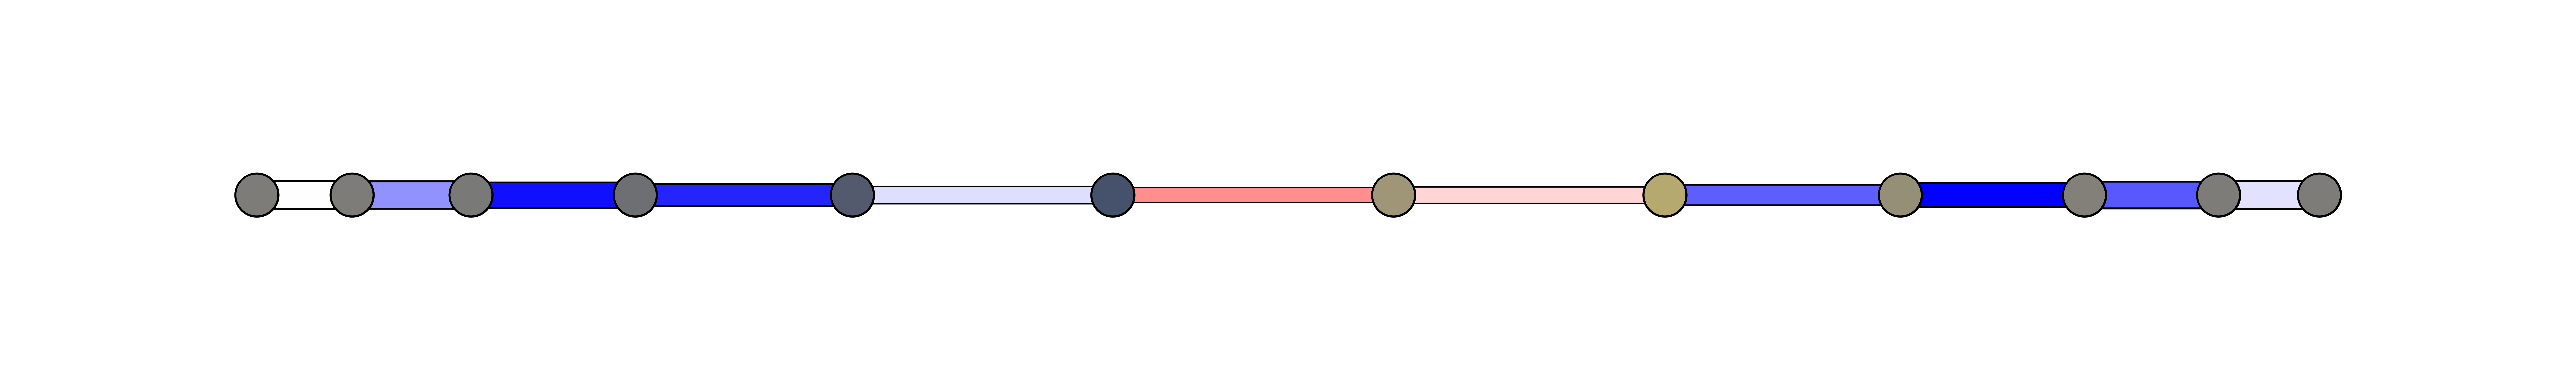

In [230]:
fig,ax = plt.subplots(figsize=(8,1),dpi=2000)
frame = 45
G = GList[frame]
pos2D = pos3D_to_2D(G)
ns=40; edgeScaling=4
pMax = np.max(np.abs(pArr)); QAbsMax = np.max(np.abs(QArr))
QAvg = np.mean(QArr,axis=0); pAvg = np.mean(pArr,axis=0); AAvg = np.mean(AArr,axis=0)
colorE=QArr[frame]; colorN=pArr[frame]; widths=edgeScaling*np.sqrt(AArr[frame]); pureRed = -QAbsMax; pureBlue = QAbsMax
nx.draw(G,with_labels=False, pos=pos2D,ax=ax,width=1.15*widths,arrows=False,edge_color='black', node_color='black',node_size=1.25*ns)
nx.draw(G,with_labels=False, pos=pos2D,ax=ax,width=widths, arrows=False,
  edge_color=colorE,edge_cmap=mpl.cm.bwr_r,edge_vmin=pureRed,edge_vmax=pureBlue,
  node_color=colorN,cmap=mpl.cm.cividis,vmin=-pMax,vmax=pMax,node_size=ns)

In [275]:
numFrames = 14
fig,axs = plt.subplots(numFrames+1,1,figsize=(8,4),dpi=2000)
ns=40; edgeScaling=5
pMax = np.max(np.abs(pArr)); QAbsMax = np.max(np.abs(QArr))

for i in range(numFrames):
    frame = int(i*Nt/numFrames)
    ax = axs[i]
    G = GList[frame]
    pos2D = pos3D_to_2D(G)
    colorE=QArr[frame]; colorN=np.linspace(0,1,len(pArr[frame])); widths=edgeScaling*np.sqrt(AArr[frame]); pureRed = -QAbsMax; pureBlue = QAbsMax

    node_background = nx.draw_networkx_nodes(G, ax=ax, pos=pos2D, 
             node_color='black',node_size=1.25*ns)
    #nodes = nx.draw_networkx_nodes(G, ax=ax, pos=pos2D, 
    #         node_color=colorN,cmap=mpl.cm.cividis,vmin=pMin,vmax=pMax,node_size=ns)
    edge_background = nx.draw_networkx_edges(G, ax=ax, pos=pos2D,width=1.25*widths, arrows=False)
    edges = nx.draw_networkx_edges(G, ax=ax, pos=pos2D,width=widths,
            edge_color=colorE,edge_cmap=mpl.cm.bwr_r,edge_vmin=pureRed,edge_vmax=pureBlue, arrows=False)
    ax.axis("off")

ax=axs[-1]
cbar = fig.colorbar(edges, ax=ax, orientation='horizontal',fraction = 1,format="%.1e",shrink=4)
cbar.set_label("Edge flows", fontsize=10)
cbar.ax.tick_params(labelsize=8)
ax.axis("off")
plt.show()

#fig.savefig('longitudinalWaveNetwork.svg', format='svg', bbox_inches='tight')

[0.10038792 0.10038792 0.10038792 0.10038792 0.10038792 0.10038792
 0.10038792 0.10038792 0.10038792 0.10038792 0.10038792]


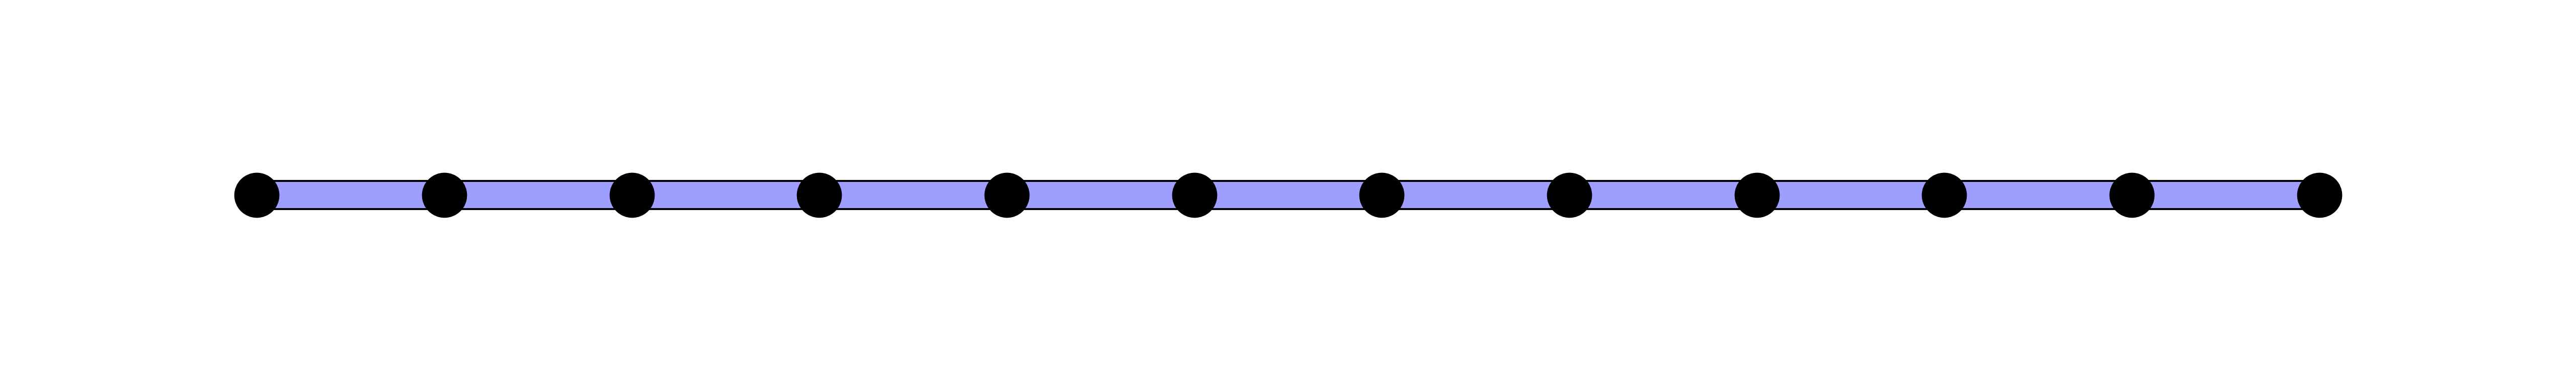

In [287]:
fig,ax = plt.subplots(figsize=(8,1),dpi=800)
G = GList[0]
pos2D = pos03D_to_2D(G)
pMax = np.max(np.abs(pArr)); QAbsMax = np.max(np.abs(QArr))
QAvg = np.mean(QArr,axis=0); pAvg = np.mean(pArr,axis=0); AAvg = np.mean(AArr,axis=0)
print(QAvg)
colorE=QAvg; colorN=pAvg; widths=edgeScaling*AAvg; pureRed = -QAbsMax; pureBlue = QAbsMax
nx.draw(G,with_labels=False, pos=pos2D,ax=ax,width=1.15*widths,arrows=False,edge_color='black', node_color='black',node_size=1.25*ns)
nx.draw(G,with_labels=False, pos=pos2D,ax=ax,width=widths, arrows=False,
  edge_color=colorE,edge_cmap=mpl.cm.bwr_r,edge_vmin=pureRed,edge_vmax=pureBlue,
  node_color='black',node_size=ns)
#fig.savefig('longitudinalWaveNetworkAvg.svg', format='svg', bbox_inches='tight')

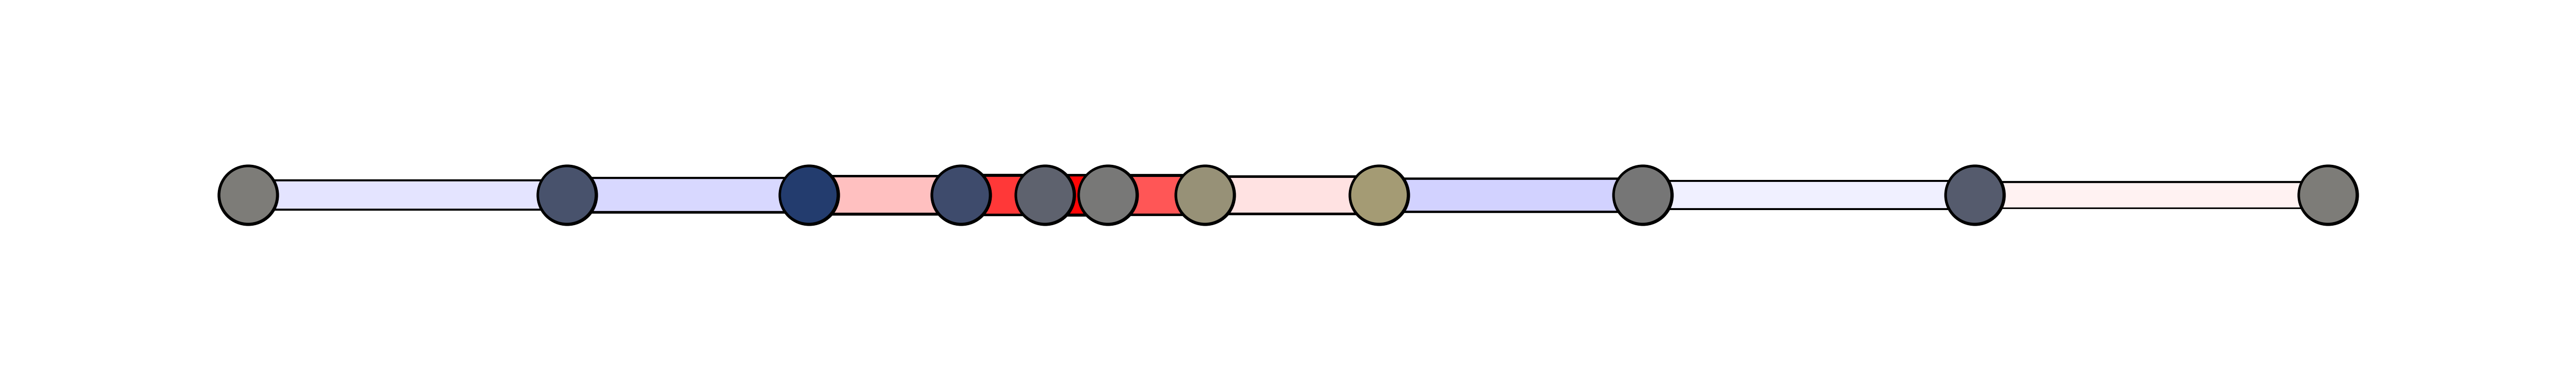

In [146]:
fig,ax = plt.subplots(figsize=(8,1),dpi=800)
ax.set_xlim(-.1,1.1); ax.set_ylim(-.2,.2); #Important to fix boundaries, make scaling in x and y the same
frameNumber = -1
p = pArr[frameNumber]; Q = roundQ(QArr[frameNumber]); G = GList[frameNumber]; A = AArr[frameNumber]
pos2D = pos3D_to_2D(G)
ns = 80; edgeScaling = 6
colorE=Q; colorN=p; widths=edgeScaling*np.sqrt(A); pureRed = -QAbsMax; pureBlue = QAbsMax
nx.draw(G,with_labels=False, pos=pos2D,ax=ax,width=1.15*widths,arrows=False,edge_color='black', node_color='black',node_size=1.25*ns)
nx.draw(G,with_labels=False, pos=pos2D,ax=ax,width=widths, arrows=False,
  edge_color=colorE,edge_cmap=mpl.cm.bwr_r,edge_vmin=pureRed,edge_vmax=pureBlue,
  node_color=colorN,cmap=mpl.cm.cividis,vmin=-pMax,vmax=pMax,node_size=ns)

In [311]:
eps = 0.5; poissonRatio = 0.5
NList = range(4,61,2)
QAvgList = np.zeros(len(NList))
for i in range(len(NList)):
    N = int(NList[i])
    t = np.linspace(0,1,80,endpoint=False)
    def simulate_linear_network(t):
        pList = []; QList = []; AList = []; GList = []
        for n in range(len(t)):
            G = Gt(t[n],eps,N)
            p,Q = solve_linear_network(G,poissonRatio)
            pList.append(list(p)); QList.append(list(Q)); AList.append(list(calcA(G,poissonRatio))); GList.append(G)
        return GList, np.array(pList), np.array(QList), np.array(AList)
    GList, pArr, QArr, AArr = simulate_linear_network(t)
    QAvg = np.mean(QArr,axis=0)[0]; 
    QAvgList[i] = QAvg

In [312]:
from scipy.integrate import quad

def dxsdXTension(xi, eta, nu):
    return 1 + eta * np.cos(2*np.pi*xi)

def rsTension(xi, eta, nu):
    return np.sqrt(1-2*nu*(eta*np.cos(2*np.pi*xi) + .5*eta**2*np.cos(2*np.pi*xi)**2))

def dvoldXTension(xi, eta, nu):
    return rsTension(xi, eta, nu)**2 * dxsdXTension(xi, eta, nu)

def integrandTension(xi, eta, nu, p, q):
    return rsTension(xi, eta, nu)**p * dxsdXTension(xi, eta, nu)**q

def qTildeTension(DP, eta, nu):
    integral2, error = quad(integrandTension, 0, 1, args=(eta, nu, -2, 2)) 
    integral3, error = quad(integrandTension, 0, 1, args=(eta, nu, -4, 1)) 
    return -DP/integral3 - integral2/integral3

#Best to avoid eta = 0 and eta = etaMax. Any values in between should work.
def qMeanTension(DP, eta, nu):
    integral1, error = quad(integrandTension, 0, 1, args=(eta, nu,  2, 1)) 
    return qTildeTension(DP, eta, nu) + integral1

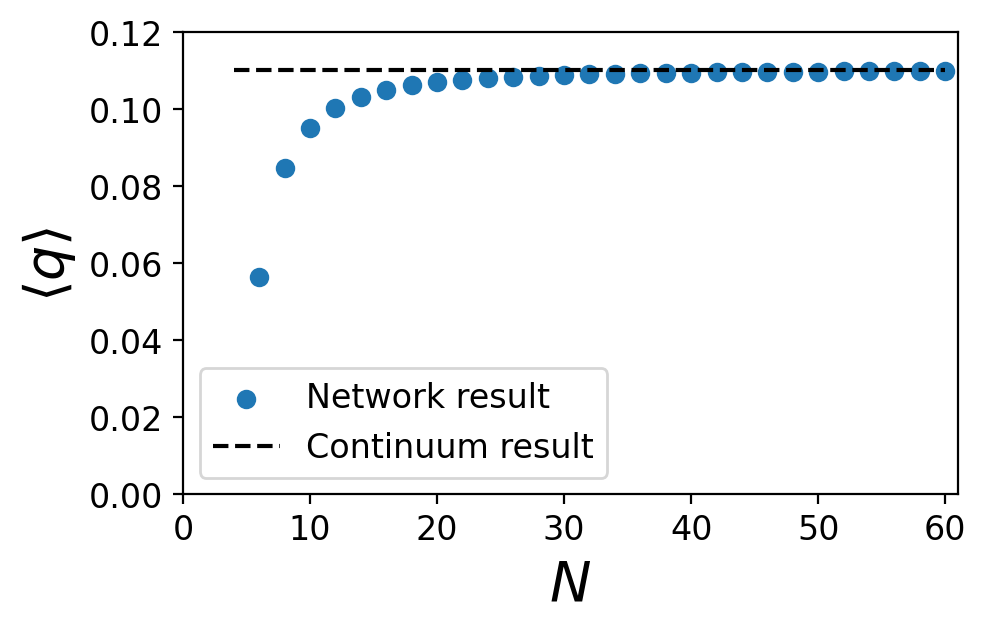

In [324]:
fig,ax = plt.subplots(figsize=(5,3),dpi=200)
qAnalytic = qMeanTension(0, eps, poissonRatio)
plt.scatter(NList,QAvgList, label='Network result')
plt.plot(NList,np.zeros(len(NList))+qAnalytic,linestyle='dashed',color='black', label='Continuum result')
plt.xlim(0,61)
plt.ylim(0,.12)
plt.xlabel(r'$N$',fontsize=20)
plt.ylabel(r'$\langle q \rangle$',fontsize=20)
plt.legend()
plt.show()
#fig.savefig('longitudinalWaveNetworkN.svg', format='svg', bbox_inches='tight')